<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Predicting Sunspots with Neural Networks (DNN only)

In the remaining labs for this week, you will move away from synthetic time series and start building models for real world data. In particular, you will train on the [Sunspots](https://www.kaggle.com/datasets/robervalt/sunspots) dataset: a monthly record of sunspot numbers from January 1749 to July 2018. You will first build a deep neural network here composed of dense layers. This will act as your baseline so you can compare it to the next lab where you will use a more complex architecture.

Let's begin!

## Imports

You will use the same imports as before with the addition of the [csv](https://docs.python.org/3/library/csv.html) module. You will need this to parse the CSV file containing the dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

You will only have the `plot_series()` dataset here because you no longer need the synthetic data generation functions.

In [2]:
def plot_series(
    x,
    y,
    format="-",
    start=0,
    end=None,
    title=None,
    xlabel=None,
    ylabel=None,
    legend=None,
):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

        # Loop over the y elements
        for y_curr in y:

            # Plot the x and current y values
            plt.plot(x[start:end], y_curr[start:end], format)

    else:
        # Plot the x and y values
        plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

You can now download the dataset and inspect the contents. The link in class is from Laurence's repo but we also hosted it in the link below.

In [3]:
# Download the dataset
!wget -P data/ https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2022-11-30 17:59:24--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘data/Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.09s   

2022-11-30 17:59:24 (771 KB/s) - ‘data/Sunspots.csv’ saved [70827/70827]



Running the cell below, you'll see that there are only three columns in the dataset:
1. untitled column containing the month number
2. Date which has the format `YYYY-MM-DD`
3. Mean Total Sunspot Number

In [5]:
# Preview the dataset
!head data/Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


For this lab and the next, you will only need the month number and the mean total sunspot number. You will load those into memory and convert it to arrays that represents a time series.

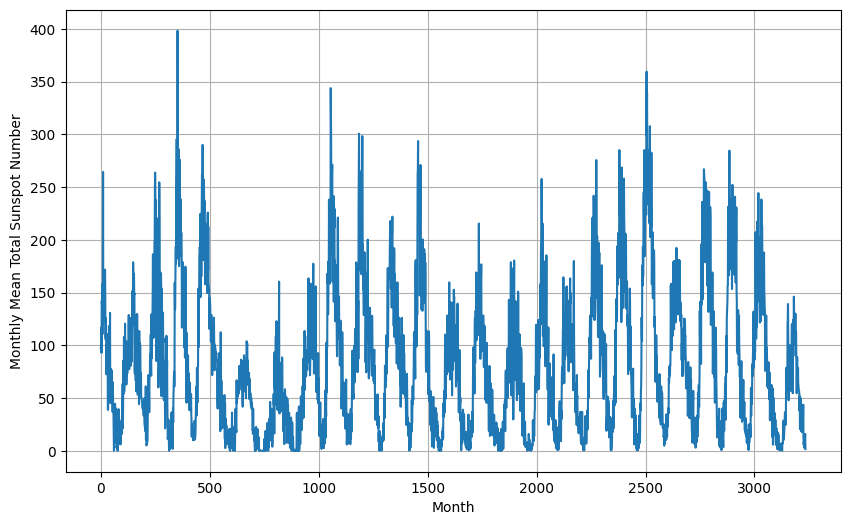

In [7]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open("./data/Sunspots.csv") as csvfile:

    # Initialize reader
    reader = csv.reader(csvfile, delimiter=",")

    # Skip the first line
    next(reader)

    # Append row and sunspot number to lists
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel="Month", ylabel="Monthly Mean Total Sunspot Number")

## Split the Dataset

Next, you will split the dataset into training and validation sets. There are 3235 points in the dataset and you will use the first 3000 for training.

In [8]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
y_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
y_valid = series[split_time:]

## Prepare Features and Labels

You can then prepare the dataset windows as before. The window size is set to 30 points (equal to 2.5 years) but feel free to change later on if you want to experiment.

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [10]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)

Metal device set to: Apple M1


2022-12-02 10:30:30.437993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 10:30:30.439616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Print properties of a single batch
for windows in train_set.take(1):
    print(f"data type: {type(windows)}")
    print(f"number of elements in the tuple: {len(windows)}")
    print(f"shape of first element: {windows[0].shape}")
    print(f"shape of second element: {windows[1].shape}")
    print(windows)

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 30)
shape of second element: (32,)
(<tf.Tensor: shape=(32, 30), dtype=float64, numpy=
array([[ 99.5,  77.2,  95. , 112.2,  99.2, 124.5,  97.2, 120. ,  80.5,
        110. , 126. , 102.2,  84.3,  99.5, 101.7, 116.7, 151.7, 134.5,
        119.5, 178.7, 165.5, 156.8, 151.8, 167.8, 147.8, 149.5,  76.7,
         73. , 121.3,  76.2],
       [ 65.8, 113.6,  57.7,  79. ,  96.3,  76.7,  93.8,  94.4,  70.4,
         89.4,  82.6,  93.5,  80.4,  76.8,  88. , 107.3, 108.5, 101.9,
        148.6, 163.4,  90.4, 127.3,  83.9,  91.1,  95. ,  78.1,  71.6,
         82.3, 120.6, 158.4],
       [ 90.5,  63.3,  61.7,  73.3,  56.7,  38.7,  52.5,  50. ,  46.7,
         64.5,  44.5,  47.2,  38.3,  42. ,  53.7,  33.3,  30. ,  13.3,
         25. ,  17.5,  21.7,  13.3,  18.3,  16.7,  10. ,  15. ,  10. ,
         16.7,  16.7,  13.3],
       [ 73.3,  64.5, 104.2,  62.8,  71.7,  71.7,  80.5,  73.3,  78. ,
         78.3,  81.7,  

2022-12-02 10:30:38.279086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Build the Model

The model will be 3-layer dense network as shown below.

In [16]:
# Build the model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


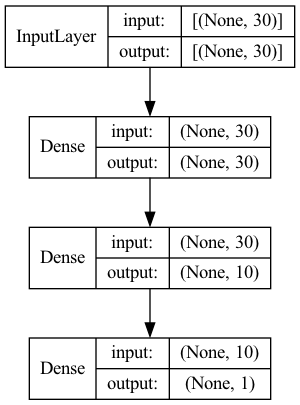

In [17]:
from keras_visualizer import visualizer
from IPython.display import Image

tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=False
)
# visualizer(model_tune, format='png')
# Image(filename='graph.png') 

## Tune the Learning Rate

You can pick a learning rate by running the same learning rate scheduler code from previous labs.

In [18]:
# Get initial weights
init_weights = model.get_weights()

In [19]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(
    train_set, 
    epochs=100, 
    callbacks=[lr_schedule],
    verbose=2
)

Epoch 1/100


2022-12-02 10:45:37.132469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 - 1s - loss: 91.9401 - lr: 1.0000e-08 - 641ms/epoch - 7ms/step
Epoch 2/100
93/93 - 0s - loss: 90.2446 - lr: 1.1220e-08 - 466ms/epoch - 5ms/step
Epoch 3/100
93/93 - 0s - loss: 88.3060 - lr: 1.2589e-08 - 408ms/epoch - 4ms/step
Epoch 4/100
93/93 - 0s - loss: 86.1093 - lr: 1.4125e-08 - 414ms/epoch - 4ms/step
Epoch 5/100
93/93 - 0s - loss: 83.6315 - lr: 1.5849e-08 - 409ms/epoch - 4ms/step
Epoch 6/100
93/93 - 0s - loss: 80.8180 - lr: 1.7783e-08 - 406ms/epoch - 4ms/step
Epoch 7/100
93/93 - 0s - loss: 77.6367 - lr: 1.9953e-08 - 406ms/epoch - 4ms/step
Epoch 8/100
93/93 - 0s - loss: 74.0522 - lr: 2.2387e-08 - 435ms/epoch - 5ms/step
Epoch 9/100
93/93 - 0s - loss: 70.0140 - lr: 2.5119e-08 - 425ms/epoch - 5ms/step
Epoch 10/100
93/93 - 0s - loss: 65.5162 - lr: 2.8184e-08 - 406ms/epoch - 4ms/step
Epoch 11/100
93/93 - 0s - loss: 60.5408 - lr: 3.1623e-08 - 412ms/epoch - 4ms/step
Epoch 12/100
93/93 - 0s - loss: 55.1540 - lr: 3.5481e-08 - 410ms/epoch - 4ms/step
Epoch 13/100
93/93 - 0s - loss: 49.51

(1e-08, 0.001, 0.0, 100.0)

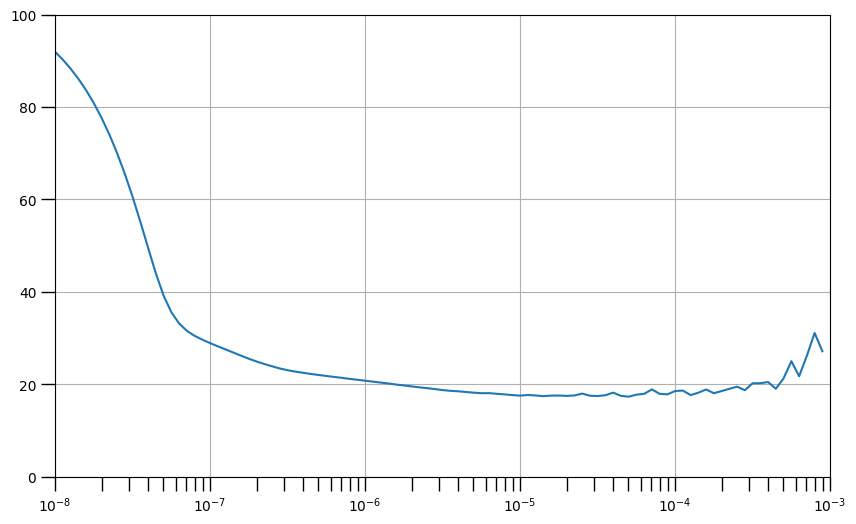

In [20]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params("both", length=10, width=1, which="both")

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Once you've picked a learning rate, you can rebuild the model and start training.

In [23]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [24]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=100, verbose=2)

Epoch 1/100


2022-12-02 10:47:29.808782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


93/93 - 1s - loss: 26.0056 - mae: 26.4990 - 671ms/epoch - 7ms/step
Epoch 2/100
93/93 - 0s - loss: 19.8536 - mae: 20.3461 - 432ms/epoch - 5ms/step
Epoch 3/100
93/93 - 0s - loss: 18.9109 - mae: 19.4022 - 431ms/epoch - 5ms/step
Epoch 4/100
93/93 - 0s - loss: 18.5500 - mae: 19.0413 - 427ms/epoch - 5ms/step
Epoch 5/100
93/93 - 0s - loss: 17.8606 - mae: 18.3509 - 431ms/epoch - 5ms/step
Epoch 6/100
93/93 - 0s - loss: 17.8634 - mae: 18.3550 - 432ms/epoch - 5ms/step
Epoch 7/100
93/93 - 0s - loss: 17.6004 - mae: 18.0920 - 443ms/epoch - 5ms/step
Epoch 8/100
93/93 - 0s - loss: 17.5852 - mae: 18.0768 - 433ms/epoch - 5ms/step
Epoch 9/100
93/93 - 0s - loss: 17.6007 - mae: 18.0920 - 435ms/epoch - 5ms/step
Epoch 10/100
93/93 - 0s - loss: 17.5653 - mae: 18.0560 - 456ms/epoch - 5ms/step
Epoch 11/100
93/93 - 0s - loss: 17.4124 - mae: 17.9040 - 442ms/epoch - 5ms/step
Epoch 12/100
93/93 - 0s - loss: 17.4979 - mae: 17.9882 - 472ms/epoch - 5ms/step
Epoch 13/100
93/93 - 0s - loss: 17.3801 - mae: 17.8715 - 434m

## Model Prediction

Now see if the model generates good results. If you used the default parameters of this notebook, you should see the predictions follow the shape of the ground truth with an MAE of around 15. 

In [25]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 0s 18ms/step


2022-12-02 10:48:54.283095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


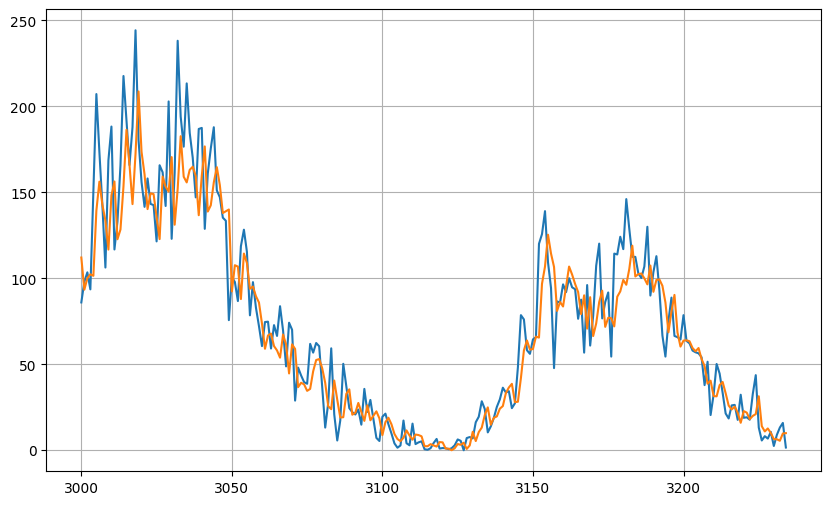

In [26]:
# Reduce the original series
forecast_series = series[split_time - window_size : -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (y_valid, results))

In [27]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(y_valid, results).numpy())

14.824228


## Wrap Up

In this lab, you built a relatively simple DNN to forecast sunspot numbers for a given month. We encourage you to tweak the parameters or train longer and see the best results you can get. In the next lab, you will build a more complex model and you evaluate if the added complexity translates to better or worse results.